In [1]:
import os, io
from pathlib import Path
import math
from operator import itemgetter
from collections import defaultdict, namedtuple, Counter, deque
from heapq import heapify, heappush, heappop
from itertools import chain
from dataclasses import dataclass, field
import itertools
import sqlite3
import logging
import logging.handlers
import multiprocessing as mp
import pickle

from tqdm.notebook import tqdm
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance

import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import preprocessing
from scipy.interpolate import RegularGridInterpolator

from utils import *
from hdc import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_4096'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

hdc = Hdc(config.hdc_n, np)

xp = numpy


In [3]:
def ensure_dataset_folder():
    if not os.path.exists(config.dataset_path):
        print(f'Creating "{config.dataset_path}"')
        os.mkdir(config.dataset_path)

def is_table_exists(db_con, table_name):
    df = pd.read_sql('SELECT name FROM sqlite_master WHERE type=:type AND name=:table_name', params={'type': 'table', 'table_name': table_name}, con=db_con)
    return len(df) > 0

def is_table_empty(db_con, table_name):
    cur = train_db_con.cursor() 
    return len(cur.execute(f'SELECT * FROM {table_name} LIMIT 1').fetchall()) < 1

def drop_table_safe(db_con, tn):
    if is_table_exists(db_con, tn):
        db_con.cursor().execute(f'DROP TABLE {tn}')
        db_con.commit()

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

ensure_dataset_folder()
train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name), autocommit=False)
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name), autocommit=False)

# Load MNIST

In [4]:
dataset_source = os.path.join(config.dataset_source)

In [5]:
import struct
from array import array

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        
        images = []
        
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images.append(img)
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

CPU times: user 210 ms, sys: 78.1 ms, total: 289 ms
Wall time: 287 ms


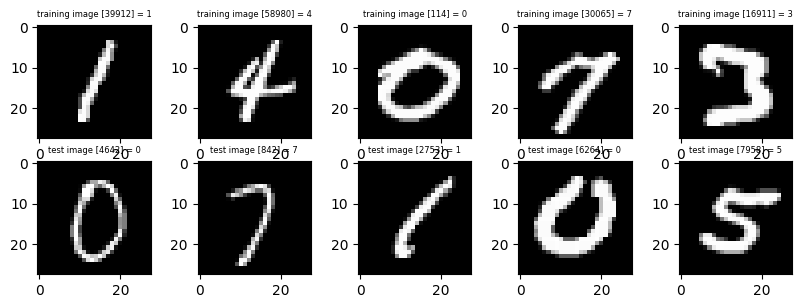

In [6]:
%%time
import random

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = os.path.join(dataset_source, 'train-images-idx3-ubyte')
training_labels_filepath = os.path.join(dataset_source, 'train-labels-idx1-ubyte')
test_images_filepath = os.path.join(dataset_source, 't10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(dataset_source, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,5))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 6);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# Create dataset

In [7]:
%run sequencing_sp.ipynb

In [8]:
# if True:
if False:
    train_tuple = (train_db_con, x_train, y_train, config.dataset_train_samples_count, 0)
    test_tuple = (test_db_con, x_test, y_test, config.dataset_test_samples_count, 100_000_000)
    
    for db_con, x, y, samples_count, id_offset in [train_tuple, test_tuple]:
        drop_table_safe(db_con, 'images')
        db_con.commit()

In [9]:
def create_dataset(x_dataset, y_dataset, samples_count, id_offset):
    image_indices = RNG.choice(len(x_dataset), samples_count, replace=False)
    image_dataset = defaultdict(list)
    sensor_instance_item_getter = itemgetter(*SensorInstance._fields)

    for i in tqdm(image_indices):
        img_data = x_dataset[i]
        img_label = y_dataset[i]
    
        with Image.frombytes('L', size=(28, 28), data=img_data) as img:
            img = img.resize((config.sample_size, config.sample_size))
            b = io.BytesIO()
            img.save(b, format='PNG')
            png = b.getvalue()
    
            image_id = i + id_offset
            image_dataset['image_id'].append(image_id)
            image_dataset['value'].append(str(img_label))
            image_dataset['png'].append(png)

            # 1)
            images_matrix = xp.array(img).ravel()[np.newaxis,:]
            sense_vectors = sense_images(images_matrix)
            assert sense_vectors.shape[0] == 1
            sense_vector = sense_vectors[0]

            # 2)
            altitude_map, df_sensor_instances = parse_sense_vector(sense_vector)
            sensor_instance_ind_dict = dict(map(lambda si: (int(si.Index), SensorInstance._make(sensor_instance_item_getter(si._asdict()))), df_sensor_instances.itertuples()))
            image_dataset['si'].append(pickle.dumps(sensor_instance_ind_dict))
            
            raw_sequences = discover_raw_sequences(sensor_instance_ind_dict, altitude_map)
            sequences = weave_raw_sequences(raw_sequences)
            sequences = cw_orient_sequences(sequences, sensor_instance_ind_dict)
            image_dataset['seq'].append(pickle.dumps(sequences))

    image_dataset = pd.DataFrame(image_dataset)
    return image_dataset

def save_dataset(image_dataset, db_con):
    image_dataset.to_sql(name='images', con=db_con)

    cur = db_con.cursor()
    cur.execute('CREATE INDEX ix_images_image_id ON images(image_id)')
    db_con.commit()

In [10]:
%%time
train_tuple = (train_db_con, x_train, y_train, config.dataset_train_samples_count, 0)
test_tuple = (test_db_con, x_test, y_test, config.dataset_test_samples_count, 100_000_000)

for db_con, x, y, samples_count, id_offset in [train_tuple, test_tuple]:
    if not is_table_exists(db_con, 'images'):
        image_dataset = create_dataset(x, y, samples_count, id_offset)
        save_dataset(image_dataset, db_con)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 34min 26s, sys: 3min 53s, total: 38min 20s
Wall time: 9min 18s


# Test dataset


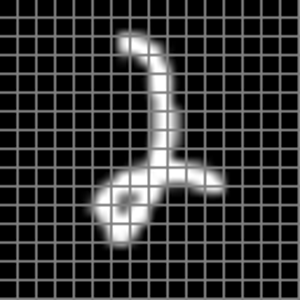
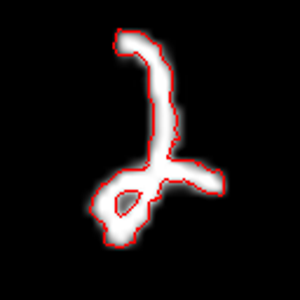
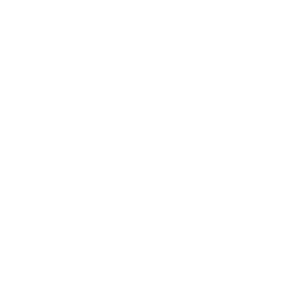
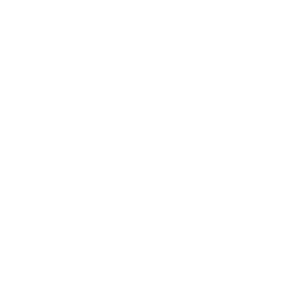
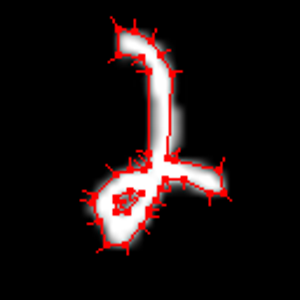

In [11]:
empty_image = Image.new('L', size=(1,1), color=255)
lay_grid_local = lambda i: lay_grid(i, 8)

images = []
captions = []

df_image_ids = pd.read_sql_query('SELECT image_id FROM images', con=train_db_con, index_col='image_id')
image_id = RNG.choice(df_image_ids.index.unique())
# image_id = 5183 # 8 with nasty adornment
# image_id = 47918 


# Image as-is
df_images = pd.read_sql_query('SELECT value, png, si, seq FROM images WHERE image_id=:image_id', con=train_db_con, params={'image_id': int(image_id)})
assert len(df_images) == 1
image_data = df_images.iloc[0]['png']
image = Image.open(io.BytesIO(image_data))
images.append(lay_grid_local(image.copy()))
captions.append(f'{image_id}, val={df_images.iloc[0]['value']}')

sensor_instance_ind_dict = pickle.loads(df_images.iloc[0]['si'])
sequences = pickle.loads(df_images.iloc[0]['seq'])
sequences_si = [list(map(lambda si_ind: sensor_instance_ind_dict[si_ind], seq)) for seq in sequences]

# Full sequence
image_pil = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=np.array(image).ravel())
image_pil = image_pil.convert('RGB')
draw = ImageDraw.Draw(image_pil)
full_seq_pts_count = 0

for seq in sequences_si:
    for si_from, si_to in zip(seq, seq[1:] + seq[:1]):
        pt_from = si_from.x, si_from.y
        pt_to = si_to.x, si_to.y
        draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')

    full_seq_pts_count += len(seq)

images.append(image_pil)
captions.append(f'full seq., points={full_seq_pts_count}')

images.extend([empty_image] * 2)
captions.extend([''] * 2)

# Simplifications of sequences
for alpha, tolerance_angle in itertools.product([0.3], [20]):
    sequences_simplified = simplify_sequences(sequences, sensor_instance_ind_dict, alpha=alpha, tolerance_angle=tolerance_angle)
    sequences_simplified_si = [list(map(lambda si_ind: sensor_instance_ind_dict[si_ind], seq)) for seq in sequences_simplified]
    
    image_pil = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=np.array(image).ravel())
    image_pil = image_pil.convert('RGB')
    draw = ImageDraw.Draw(image_pil)
    pts_count = 0
    
    for seq in sequences_simplified_si:
        for si_from, si_to in zip(seq, seq[1:] + seq[:1]):
            pt_from = si_from.x, si_from.y
            pt_to = si_to.x, si_to.y
            draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')
    
            draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline='red')
            normal_vec = si_from.normal_vec
            draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * 5, pt_from[1] + normal_vec.imag * 5], width=1, fill='red')
    
            draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline='red')
            normal_vec = si_to.normal_vec
            draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * 5, pt_to[1] + normal_vec.imag * 5], width=1, fill='red')

        pts_count += len(seq)

    images.append(image_pil)
    captions.append(f'{alpha}/{tolerance_angle}, points={pts_count} ({pts_count/full_seq_pts_count*100:.0f}%)')
    
display_images_grid(list(map(lambda i: i.resize((300, 300)), images)), captions=captions, col_count=4)